# Preprocessed Citibike Data: Exploratory Data Analysis

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pandas.api.types import CategoricalDtype
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## Import and load data

Import preprocessed data:

In [2]:
cb_raw = pd.read_csv('../../data/02_processed/concat_file_processed_final.csv', 
                     parse_dates=['starttime', 'stoptime'])

Make a copy: 

In [3]:
cb = cb_raw.copy()

## Inspect data frame

Get dimensions of data frame and datatypes of each feature:

In [4]:
cb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4017571 entries, 0 to 4017570
Data columns (total 15 columns):
bikeid                   int64
birthyear                int64
endstationid             int64
endstationlatitude       float64
endstationlongitude      float64
endstationname           object
gender                   int64
startstationid           int64
startstationlatitude     float64
startstationlongitude    float64
startstationname         object
starttime                datetime64[ns]
stoptime                 datetime64[ns]
tripduration             int64
usertype                 object
dtypes: datetime64[ns](2), float64(4), int64(6), object(3)
memory usage: 459.8+ MB


Randomly sample five observations:

In [5]:
cb.sample(n=5)

,bikeid,birthyear,endstationid,endstationlatitude,endstationlongitude,endstationname,gender,startstationid,startstationlatitude,startstationlongitude,startstationname,starttime,stoptime,tripduration,usertype
1456032,28912,1990,267,40.75,-74.00,Broadway & W 36 St,1,3725,40.78,-73.94,2 Ave & E 72 St,2019-04-08 18:01:31.192,2019-04-08 18:18:02.319,991,Subscriber
3863119,25242,1954,280,40.72,-74.00,E 10 St & 5 Ave,1,382,40.75,-74.00,University Pl & E 14 St,2017-06-19 09:12:20.000,2017-06-19 09:16:08.000,228,Subscriber
1639258,19194,1988,3107,40.72,-73.94,Bedford Ave & Nassau Ave,2,3112,40.72,-73.94,Milton St & Franklin St,2017-07-16 00:14:07.000,2017-07-16 00:19:04.000,296,Subscriber
3749045,32451,1972,161,40.72,-74.00,LaGuardia Pl & W 3 St,1,280,40.72,-74.00,E 10 St & 5 Ave,2019-05-30 10:17:06.196,2019-05-30 10:22:12.011,305,Subscriber
2211039,26495,1974,232,40.70,-74.00,Cadman Plaza E & Tillary St,2,3112,40.72,-73.94,Milton St & Franklin St,2017-08-06 10:30:56.000,2017-08-06 10:57:23.000,1587,Subscriber


Check for missing values – there should be none:

In [6]:
cb.isnull().sum()

bikeid                   0
birthyear                0
endstationid             0
endstationlatitude       0
endstationlongitude      0
endstationname           0
gender                   0
startstationid           0
startstationlatitude     0
startstationlongitude    0
startstationname         0
starttime                0
stoptime                 0
tripduration             0
usertype                 0
dtype: int64

## Data preprocessing

Show unique values per feature:

In [7]:
pd.DataFrame.from_records([(col, cb[col].nunique()) for col in cb.columns],
                          columns=['Feature', 'Number of Unique Values']).sort_values(by=['Number of Unique Values'])

,Feature,Number of Unique Values
6,gender,3
9,startstationlongitude,3
14,usertype,3
4,endstationlongitude,4
3,endstationlatitude,6
8,startstationlatitude,6
1,birthyear,85
7,startstationid,1050
2,endstationid,1066
10,startstationname,1080


### Define features

Define numerical features:

In [8]:
map_feat = ['endstationlatitude','endstationlongitude','startstationlatitude','startstationlongitude']
datetime_feat = ['birthyear','starttime', 'stoptime']
cont_feat = map_feat + datetime_feat + ['tripduration']

Define categorical features:

In [9]:
num_nom_feat = ['bikeid','endstationid','startstationid','gender']
cat_nom_feat = ['endstationname','startstationname','usertype']
nom_feat = num_nom_feat + cat_nom_feat

### Perform datatype conversions

Convert to datetime format:

In [10]:
cb['birthyear'] = pd.to_datetime(cb.birthyear, format='%Y')

Convert features to `float16` or `int16` to reduce memory:

In [11]:
cb[map_feat] = cb[map_feat].apply(lambda x: x.astype('float16'))

In [12]:
float_to_int = ['startstationid','endstationid','tripduration','bikeid','gender']

cb[float_to_int] = cb[float_to_int].apply(lambda x: x.astype('int16'))

Convert untreated nominal features to categorical datatype to reduce memory:

In [13]:
cb[cat_nom_feat] = cb[cat_nom_feat].apply(lambda x: x.astype('category'))

Check for successful datatype conversion and reduction in memory:

In [14]:
cb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4017571 entries, 0 to 4017570
Data columns (total 15 columns):
bikeid                   int16
birthyear                datetime64[ns]
endstationid             int16
endstationlatitude       float16
endstationlongitude      float16
endstationname           category
gender                   int16
startstationid           int16
startstationlatitude     float16
startstationlongitude    float16
startstationname         category
starttime                datetime64[ns]
stoptime                 datetime64[ns]
tripduration             int16
usertype                 category
dtypes: category(3), datetime64[ns](3), float16(4), int16(5)
memory usage: 180.2 MB


## Feature engineering

### Imputation

Check observations where latitude and longitude don't make any sense:

In [15]:
# observe = [4455178, 2022803, 2051817, 3007606, 2022782, 2035624, 3539070, 956266]
# cb.iloc[observe,:]

Correct errors and impute most likely values:

In [16]:
# cb.loc[cb['endstationlatitude'] == 0, 'endstationlatitude'] = 40.75
# cb.loc[cb['endstationlongitude'] == 0, 'endstationlongitude'] = -74.0
# cb.loc[cb['startstationlongitude']==0, 'startstationlongitude'] = -74.0
# cb.loc[cb['startstationlatitude'] == 0, 'startstationlatitude'] = 40.75

Drop observation where `startstationname` reads "WS Don't Use":

In [17]:
# cb.drop(4455178, axis=0, inplace=True)

### Distance features

Define helper function to calculate distance between coordinates:

In [18]:
from pyproj import Geod

def calc_vincenty_dist(lat1, lon1, lat2, lon2): 
    az12, az21, dist = Geod(ellps='WGS84').inv(lon1, lat1, lon2, lat2)
    return dist

In [19]:
# Haversine & inclination 29 degrees to True north
# Credits: https://www.movable-type.co.uk/scripts/latlong.html,
# https://gist.github.com/jkAtGitHub/8ae7da4d5dacb9969bff43500b5efbc0#file-manhattan_dist-py
def calc_haversine_dist(lat1, lon1, lat2, lon2):
    lat1, lat2, lon1, lon2 = np.radians(lat1), np.radians(lat2), np.radians(lon1), np.radians(lon2)
    dlat, dlon = lat2 - lat1, lon2 - lon1
    r = 3963 # Earth's radius in miles
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)) 
    
    total_dist = r * c
    return total_dist

def calc_manh_disth(lat1, lon1, lat2, lon2):
    start = np.stack([lat1, lon1], axis=1)
    end = np.stack([lat2, lon2], axis=1)
    
    theta1, theta2 = np.radians(-28.904), np.radians(28.904)
    rmat1 = np.array([[np.cos(theta1), np.sin(theta1)], 
                      [-np.sin(theta1), np.cos(theta1)]])
    rmat2 = np.array([[np.cos(theta2), np.sin(theta2)], 
                      [-np.sin(theta2), np.cos(theta2)]])
    
    start_rot = rmat1 @ start.T
    end_rot = rmat1 @ end.T
    
    hinge = np.stack((start_rot[0,:], end_rot[1,:]))
    hinge_coords = rmat2 @ hinge
    
    manh_dist = calc_haversine_dist(start.T[0], start.T[1], hinge_coords[0], hinge_coords[1]) + calc_haversine_dist(hinge_coords[0], hinge_coords[1], end.T[0], end.T[1])
    return manh_dist

# Unused functions -----------------------------------------------
# # Cartesian Coordinate system, output in latlong dist
# def calc_manh_distc(lat, lon):
#     return sum(abs(lat_i-lat_j) for lat_i, lat_j in zip(lat, lon))

Create new features, `vicentydistance` and `manhdistance` (both in miles):

In [20]:
cb['vicentydistance'] = calc_vincenty_dist(cb.startstationlatitude.tolist(), 
                                        cb.startstationlongitude.tolist(),
                                        cb.endstationlatitude.tolist(),
                                        cb.endstationlongitude.tolist())
cb['vicentydistance'] = cb['vicentydistance'].apply(lambda x: x*0.000621371).astype('float16') # Convert from meters to miles

In [21]:
cb['manhdistance'] = calc_manh_disth(cb.startstationlatitude,
                                     cb.startstationlongitude,
                                     cb.endstationlatitude,
                                     cb.endstationlongitude).astype('float16')

### Datetime features

Create new features, `startmonth` and `endmonth`:

In [22]:
cb['startmonth'] = cb['starttime'].dt.month.astype('int16')
cb['stopmonth'] = cb['stoptime'].dt.month.astype('int16')

Create new features for days of week, `startdayname` and `enddayname` (along with their numerical codes):

In [23]:
cb['startdayname'] = cb['starttime'].dt.day_name().astype('category')
cb['startday'] = cb['starttime'].dt.dayofweek.astype('int16')
cb['stopdayname'] = cb['stoptime'].dt.day_name().astype('category')
cb['stopday'] = cb['stoptime'].dt.dayofweek.astype('int16')

Create new features, `starthour` and `endhour`:

In [24]:
cb['starthour'] = cb['starttime'].dt.hour.astype('int16')
cb['endhour'] = cb['stoptime'].dt.hour.astype('int16')

### Geographic features

Create new features, `startboro`, `endboro`, `startneighborhood`, and `endneighborhood`::

In [25]:
from geopy.geocoders import Nominatim

In [26]:
cb['startcoords'] = list(zip(cb.startstationlatitude, cb.startstationlongitude))
cb['endcoords'] = list(zip(cb.endstationlatitude, cb.endstationlongitude))

In [27]:
cb.groupby(['startcoords','endcoords']).size()

startcoords          endcoords           
(40.65625, -74.0)    (40.65625, -74.0)        7457
                     (40.65625, -73.9375)      561
                     (40.6875, -74.0)        12659
                     (40.6875, -73.9375)      1464
                     (40.71875, -74.0)         859
                                             ...  
(40.8125, -73.9375)  (40.75, -73.9375)         693
                     (40.78125, -74.0)       10959
                     (40.78125, -73.9375)    10823
                     (40.8125, -74.0)          913
                     (40.8125, -73.9375)     19453
Length: 151, dtype: int64

In [28]:
cb['startcoords'].value_counts()

(40.75, -74.0)          1611643
(40.71875, -74.0)       1225486
(40.6875, -74.0)         303974
(40.78125, -74.0)        253155
(40.78125, -73.9375)     169885
(40.71875, -73.9375)     166405
(40.75, -73.9375)        125906
(40.6875, -73.9375)       79243
(40.8125, -73.9375)       49122
(40.65625, -74.0)         23641
(40.8125, -74.0)           4838
(40.65625, -73.9375)       4239
(40.6875, -73.875)           30
(40.71875, -73.875)           4
Name: startcoords, dtype: int64

In [29]:
cb['endcoords'].value_counts()

(40.75, -74.0)          1606408
(40.71875, -74.0)       1242812
(40.6875, -74.0)         310908
(40.78125, -74.0)        240335
(40.78125, -73.9375)     168279
(40.71875, -73.9375)     166978
(40.75, -73.9375)        125961
(40.6875, -73.9375)       76363
(40.8125, -73.9375)       47487
(40.65625, -74.0)         23251
(40.8125, -74.0)           4626
(40.65625, -73.9375)       4097
(40.6875, -73.875)           36
(40.71875, -74.0625)         29
(40.71875, -73.875)           1
Name: endcoords, dtype: int64

In [30]:
cb.groupby(['startcoords','startstationname','startstationid']).size()

startcoords          startstationname          startstationid
(40.65625, -74.0)    10 St & 5 Ave             3317               916
                     10 St & 7 Ave             3306              1338
                     12 St & 4 Ave             3322               588
                     14 St & 5 Ave             3319              1414
                     14 St & 7 Ave             3310              1377
                                                                 ... 
(40.8125, -73.9375)  W 116 St & Amsterdam Ave  3539              1158
                     W 116 St & Broadway       3536              1130
                     W 120 St & Claremont Ave  3623               685
                     W 129 St & Convent Ave    3649               307
                     West End Ave & W 107 St   3366              1590
Length: 1112, dtype: int64

In [31]:
cb.groupby(['endcoords','endstationname','endstationid']).size()

endcoords            endstationname            endstationid
(40.65625, -74.0)    10 St & 5 Ave             3317             859
                     10 St & 7 Ave             3306            1281
                     12 St & 4 Ave             3322             615
                     14 St & 5 Ave             3319            1377
                     14 St & 7 Ave             3310            1328
                                                               ... 
(40.8125, -73.9375)  W 116 St & Amsterdam Ave  3539             880
                     W 116 St & Broadway       3536             842
                     W 120 St & Claremont Ave  3623             563
                     W 129 St & Convent Ave    3649             323
                     West End Ave & W 107 St   3366            1442
Length: 1129, dtype: int64

Create data frame `unique_coords` consisting of unique coordinates for reverse geocoding processing:

In [32]:
unique_startcoords = pd.Series(cb['startcoords'].unique())
unique_endcoords = pd.Series(cb['endcoords'].unique())
unique_coords = pd.concat([unique_startcoords, unique_endcoords], axis=1)
unique_coords.columns = ['startcoords','endcoords']

In [33]:
unique_coords

,startcoords,endcoords
0,"(40.71875, -74.0)","(40.71875, -74.0)"
1,"(40.75, -74.0)","(40.75, -74.0)"
2,"(40.71875, -73.9375)","(40.6875, -74.0)"
3,"(40.6875, -74.0)","(40.71875, -73.9375)"
4,"(40.75, -73.9375)","(40.65625, -74.0)"
5,"(40.78125, -74.0)","(40.6875, -73.9375)"
6,"(40.78125, -73.9375)","(40.78125, -74.0)"
7,"(40.65625, -74.0)","(40.78125, -73.9375)"
8,"(40.8125, -73.9375)","(40.8125, -73.9375)"
9,"(40.6875, -73.9375)","(40.8125, -74.0)"


Reverse geocode station coordinates for borough and neighborhood:

In [34]:
geolocator = Nominatim(user_agent='myGeocoder', timeout=10)

In [35]:
unique_coords['startneighborhood'] = unique_coords['startcoords'].dropna().apply(lambda x: geolocator.reverse(x).address.split(',')[2].strip())

In [36]:
unique_coords['startboro'] = unique_coords['startcoords'].dropna().fillna(0).apply(lambda x: geolocator.reverse(x).address.split(',')[4].strip())

In [37]:
unique_coords['endneighborhood'] = unique_coords['endcoords'].apply(lambda x: geolocator.reverse(x).address.split(',')[2].strip())

In [38]:
unique_coords['endboro'] = unique_coords['endcoords'].apply(lambda x: geolocator.reverse(x).address.split(',')[4].strip())

Merge `unique_coords` into `cb`:

In [39]:
cb = pd.merge(cb.set_index('startcoords'), unique_coords.set_index('startcoords'), right_index=True, left_index=True, how='outer').reset_index()

In [40]:
cb = cb.drop(columns=['startcoords','endcoords_x','endcoords_y'])

In [41]:
cb[cb.isnull().any(axis=1)]

,bikeid,birthyear,endstationid,endstationlatitude,endstationlongitude,endstationname,gender,startstationid,startstationlatitude,startstationlongitude,...,startdayname,startday,stopdayname,stopday,starthour,endhour,startneighborhood,startboro,endneighborhood,endboro
4017571,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Middle Village,Queens County


In [42]:
cb = cb.dropna()

In [43]:
cb.shape

(4017571, 29)

In [44]:
cb.columns[cb.isnull().sum() > 0]

Index([], dtype='object')

Perform datatype conversion to reduce memory:

In [45]:
cat_nom_feat = cat_nom_feat + ['startneighborhood','startboro','endneighborhood','endboro']
cb[cat_nom_feat] = cb[cat_nom_feat].apply(lambda x: x.astype('category'))

In [46]:
cb[float_to_int] = cb[float_to_int].apply(lambda x: x.astype('int16'))

In [47]:
time_feat = ['startmonth','stopmonth','startday','stopday',
            'starthour','endhour']

cb[time_feat] = cb[time_feat].apply(lambda x: x.astype('float16'))

### Final check

Inspect memory:

In [48]:
cb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4017571 entries, 0 to 4017570
Data columns (total 29 columns):
bikeid                   int16
birthyear                datetime64[ns]
endstationid             int16
endstationlatitude       float16
endstationlongitude      float16
endstationname           category
gender                   int16
startstationid           int16
startstationlatitude     float16
startstationlongitude    float16
startstationname         category
starttime                datetime64[ns]
stoptime                 datetime64[ns]
tripduration             int16
usertype                 category
vicentydistance          float16
manhdistance             float16
startmonth               float16
stopmonth                float16
startdayname             category
startday                 float16
stopdayname              category
stopday                  float16
starthour                float16
endhour                  float16
startneighborhood        category
startboro   

Create csv file of feature engineering citibike dataset:

In [49]:
cb.to_csv('../../data/02_processed/citibike_feature_engineered_final.csv', index=False)

## Inspect data

### STUFF TO FIX 

In [50]:
#need to fix ride discrepencies here before proceeding with using day of week EDA seriously
len(cb.startday)-(cb.startday==cb.stopday).sum()

13746

In [51]:
cb.startday.value_counts()

2.0    639716
3.0    621666
1.0    616602
4.0    600303
0.0    579112
5.0    497901
6.0    462271
Name: startday, dtype: int64

Inspect number of rides per day:

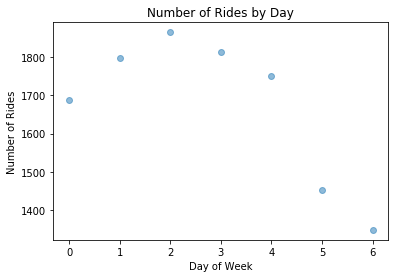

In [52]:
x=cb.startday.value_counts().index
y=cb.startday.value_counts()/(343) #divide by number of weeks to get mean rides per day
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Day of Week')
plt.ylabel('Number of Rides')
plt.title('Number of Rides by Day')
plt.show()

Inspect number of rides per hour:

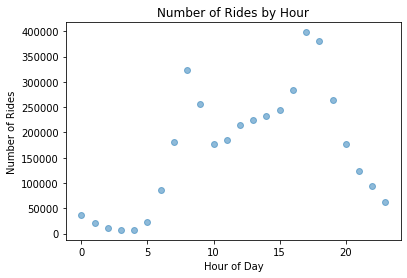

In [53]:
x=cb.starthour.value_counts().index
y=cb.starthour.value_counts()
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.title('Number of Rides by Hour')
plt.show()

Inspect number of rides per month:

In [54]:
index=[1,7,8,9,10,11,12]
#y[index] = y[index]*(6/7) #to fix over sampling from Jan 2020 and July-December 2013
y = y.round().astype('int32')

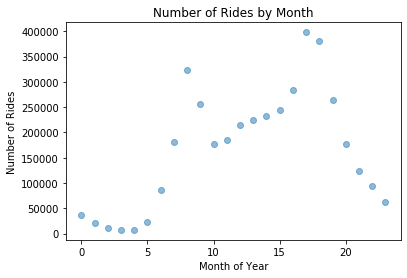

In [55]:
#ad-hocly adjusted for the oversampling of Jan, July-December months 
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Month of Year')
plt.ylabel('Number of Rides')
plt.title('Number of Rides by Month')
plt.show()

Inspect `vicentydistance` by month:

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



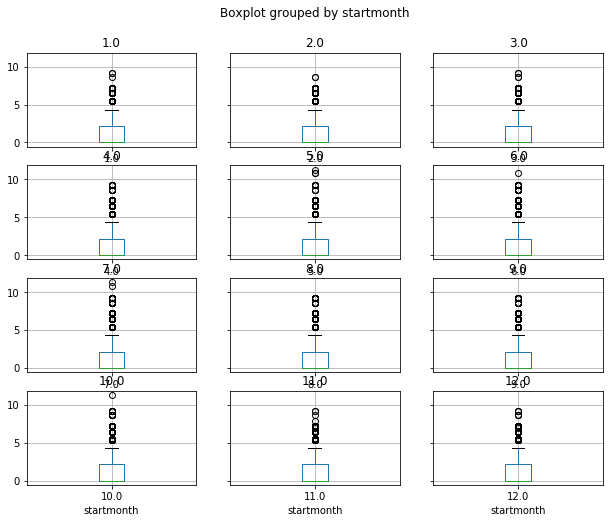

In [56]:
#adjusted for ease of interpretation
x=cb['vicentydistance'].sort_values(ascending=False).index
y=cb['vicentydistance'].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
cb.groupby('startmonth').boxplot(column=['vicentydistance'], by='startmonth', ax=ax)
plt.show()

## Appendix

Create new feature, `uniquetripid`:

In [57]:
cb_filtered = cb[cb['birthyear'].dt.year.astype('int16') > 1920]
cb_filtered['birthyear'] = cb_filtered['birthyear'].dt.year.astype('int16')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [58]:
cb_filtered.groupby(['birthyear','gender','usertype','startstationid','starttime','startneighborhood']).size()

birthyear  gender  usertype    startstationid  starttime                startneighborhood                  
1921       1       Subscriber  116             2016-07-20 17:06:09.000  Flower District                        1
                                               2016-08-24 17:10:05.000  Flower District                        1
                               160             2014-05-18 00:48:37.000  Flower District                        1
                               217             2013-06-25 19:56:56.000  Columbia Street Waterfront District    1
                               228             2014-09-02 19:25:14.000  Flower District                        1
                                                                                                              ..
2003       2       Subscriber  3361            2020-01-06 18:25:57.369  Columbia Street Waterfront District    1
                               3377            2019-12-31 23:46:46.006  Columbia Street Waterfront Di

In [59]:
cb_filtered.groupby(['startneighborhood','startstationid','starttime','usertype','birthyear','gender']).size()

startneighborhood   startstationid  starttime                usertype    birthyear  gender
Bedford-Stuyvesant  120             2013-06-04 22:40:26.000  Subscriber  1961       1         1
                                    2013-06-05 09:05:23.000  Subscriber  1973       1         1
                                    2013-06-06 09:02:34.000  Subscriber  1973       1         1
                                    2013-06-11 07:31:48.000  Subscriber  1970       1         1
                                    2013-06-11 08:45:09.000  Subscriber  1978       2         1
                                                                                             ..
Weehawken           3810            2020-01-12 16:14:20.125  Subscriber  1990       1         1
                                    2020-01-13 09:03:52.020  Subscriber  1989       2         1
                                    2020-01-13 16:58:37.596  Subscriber  1965       1         1
                                    2020-01-1